In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import ants

from aind_smartspim_transform_utils.CoordinateTransform import CoordinateTransform
from aind_smartspim_transform_utils.utils.utils import AcquisitionAxis

In [16]:
import tensorstore


In [17]:
raw.shape

(1, 1, 720, 1104, 480)

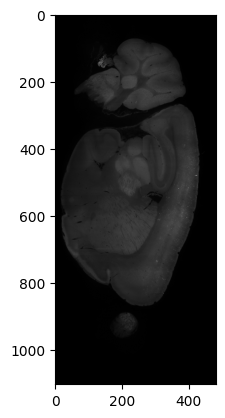

In [18]:
plt.imshow(raw[0, 0, 200], cmap='gray')
plt.show()

In [5]:
os.environ['AWS_PROFILE'] = '533267145346_ProductionRW'

In [1]:
from aind_smartspim_transform_utils.utils.utils import AcquisitionDirection, AcquisitionAxis
from skimage.exposure import rescale_intensity
from skimage.transform import resize
from deep_ccf_registration.datasets.slice_dataset import _create_coordinate_dataframe
from pathlib import Path
import json
import tensorstore
from aind_smartspim_transform_utils.CoordinateTransform import CoordinateTransform
import numpy as np
from deep_ccf_registration.utils.utils import sample_template_at_points
import matplotlib.pyplot as plt

def align_points(base_path: Path, slice_index: int, channel: str):
    with open(base_path / 'acquisition.json') as f:
        acquisition = json.load(f)

    raw = tensorstore.open(f'file://{base_path}/{channel}.zarr/3', read=True).result()[:].read().result()

    coord_transform = CoordinateTransform(
        name='smartspim_lca',
        dataset_transforms={
            'points_to_ccf': [
                str(base_path / 'ls_to_template_SyN_0GenericAffine.mat'),
                # str(base_path / 'ls_to_template_SyN_1InverseWarp.nii.gz'),
            ]
        },
        acquisition=acquisition,
        image_metadata={'shape': np.array(raw.shape[2:]) * 8}
    )

    acquisition_axes = [AcquisitionAxis.model_validate(x) for x in acquisition['axes']]


    slice_axis = [i for i in range(len(acquisition_axes)) if
                  acquisition_axes[i].direction in (AcquisitionDirection.LEFT_TO_RIGHT,
                                        AcquisitionDirection.RIGHT_TO_LEFT)]
    slice_axis = acquisition_axes[slice_axis[0]]

    spatial_dims = sorted([x for x in acquisition_axes if x != slice_axis], key=lambda x: x.dimension)

    slice_height, slice_width = [raw.shape[spatial_dims[0].dimension + 2]*8, raw.shape[spatial_dims[1].dimension + 2]*8]

    input_points = _create_coordinate_dataframe(
        height=slice_height,
        width=slice_width,
        fixed_index_value=slice_index*8,
        slice_axis=slice_axis,
        axes=acquisition_axes
    )

    ls_template_points = coord_transform.forward_transform(
        points=input_points,
    )

    ls_template_on_input = resize(sample_template_at_points(
        template_points=torch.tensor(ls_template_points.values),
        template=coord_transform.ls_template
    ).reshape((slice_height, slice_width)), output_shape=(int(slice_height/8), int(slice_width/8)))

    volume_slice = [0, 0, slice(None), slice(None), slice(None)]
    volume_slice[slice_axis.dimension + 2] = slice_index

    input_slice = raw[tuple(volume_slice)]
    raw_rgb = np.zeros_like(input_slice, shape=(*input_slice.shape, 3))
    raw_rgb[:, :, 0] = input_slice

    ls_template_on_input_rgb = np.zeros_like(ls_template_on_input, shape=(*ls_template_on_input.shape, 3))
    ls_template_on_input_rgb[:, :, 2] = ls_template_on_input

    fig, ax = plt.subplots(figsize=(10, 10), ncols=3)
    ax[0].imshow(rescale_intensity(raw_rgb, out_range=(0, 1)), alpha=0.8)
    ax[0].imshow(rescale_intensity(ls_template_on_input_rgb, out_range=(0, 1)), alpha=0.4)
    ax[1].imshow(input_slice, cmap='gray')
    ax[1].set_title('input')
    ax[2].imshow(ls_template_on_input, cmap='gray')
    ax[2].set_title('LS template')
    plt.tight_layout()
    plt.show()

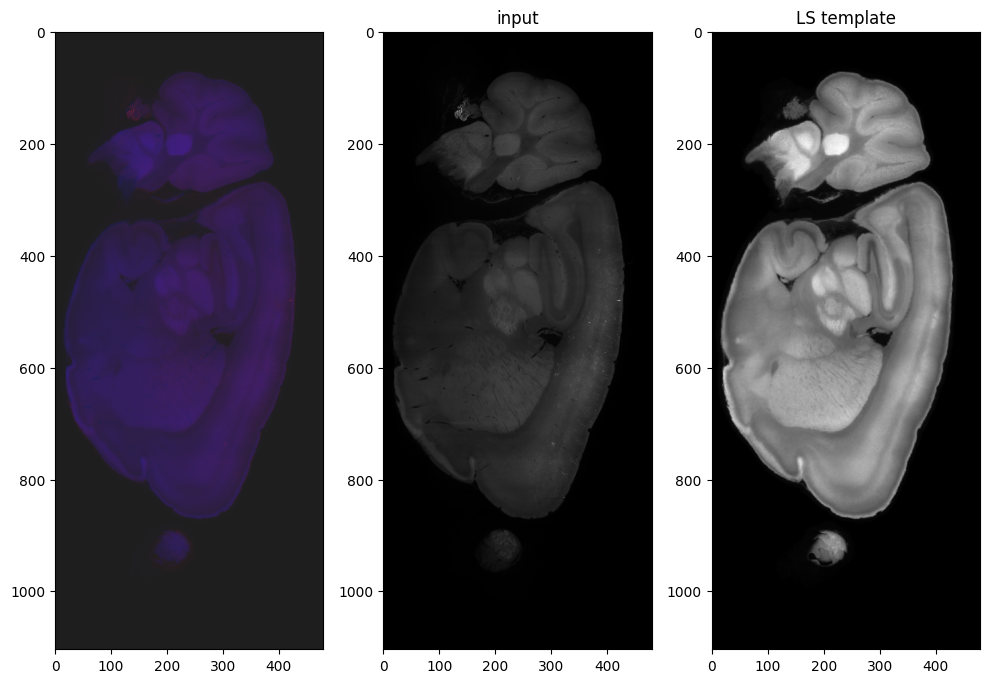

In [5]:
align_points(base_path=Path('/Users/adam.amster/Downloads/SmartSPIM_806624_2025-08-27_15-42-18_stitched_2025-08-28_13-34-06'), slice_index=200, channel='Ex_639_Em_680')

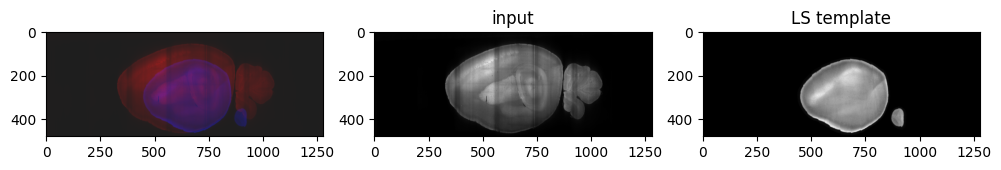

In [2]:
align_points(base_path=Path('/Users/adam.amster/Downloads/SmartSPIM_681227_2023-07-07_11-21-34_stitched_2023-07-24_20-38-50'), slice_index=200, channel='Ex_639_Em_660')

In [11]:
input_points.shape, ls_template_points.shape

((529920, 3), (529920, 3))

In [12]:
coord_transform.ls_template

ANTsImage (RAS)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (576, 648, 440)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (-1.5114, -1.5, 1.5)
	 Direction  : [ 1.  0.  0.  0.  1.  0.  0.  0. -1.]

In [8]:
def sample_ls_template_at_points(ls_template_points: pd.DataFrame, ls_template: ants.ANTsImage, interpolation='nearest'):
    ls_template_points = ls_template_points.values
    ls_template = ls_template.numpy()

    # Check bounds
    valid_mask = (
        (ls_template_points[:, 0] >= 0) & (ls_template_points[:, 0] < ls_template.shape[0]) &
        (ls_template_points[:, 1] >= 0) & (ls_template_points[:, 1] < ls_template.shape[1]) &
        (ls_template_points[:, 2] >= 0) & (ls_template_points[:, 2] < ls_template.shape[2])
    )

    values = np.zeros(len(ls_template_points))

    if interpolation == 'nearest':
        # Round to nearest integer
        ls_template_points = np.floor(ls_template_points[valid_mask]).astype(int)
        values[valid_mask] = ls_template[
            ls_template_points[:, 0],
            ls_template_points[:, 1],
            ls_template_points[:, 2]
        ]
    else:
        raise NotImplementedError

    return values, valid_mask

In [9]:
import torch

def sample_template_at_points(
    template_points: torch.Tensor,
    template: ants.ANTsImage,
    interpolation='nearest'
) -> np.ndarray:
    # flatten
    #template_points = template_points.reshape((-1, 3))

    # Check bounds
    valid_mask = (
            (template_points[:, 0] >= 0) & (template_points[:, 0] < template.shape[0]) &
            (template_points[:, 1] >= 0) & (template_points[:, 1] < template.shape[1]) &
            (template_points[:, 2] >= 0) & (template_points[:, 2] < template.shape[2])
    )

    values = np.zeros(len(template_points))

    if interpolation == 'nearest':
        # Round to nearest integer
        template_points = template_points[valid_mask].floor().int().cpu().numpy()
        values[valid_mask.cpu().numpy()] = template.numpy()[
            template_points[:, 0],
            template_points[:, 1],
            template_points[:, 2]
        ]
    else:
        raise NotImplementedError

    return values

In [11]:
def visualize_alignment(input_slice: torch.Tensor, template_points: torch.Tensor, template: ants.ANTsImage):
    raw_rgb = np.zeros_like(input_slice, shape=(*input_slice.shape, 3))
    raw_rgb[:, :, 0] = input_slice

    template_on_input = sample_template_at_points(
        template=template,
        template_points=template_points
    )
    template_on_input_rgb = np.zeros_like(template_on_input,
                                             shape=(*input_slice.shape, 3))
    template_on_input_rgb[:, :, 2] = template_on_input.reshape(input_slice.shape)

    fig, ax = plt.subplots(figsize=(10, 10), ncols=3)
    ax[0].imshow(rescale_intensity(raw_rgb, out_range=(0, 1)), alpha=0.8)
    ax[0].imshow(rescale_intensity(template_on_input_rgb, out_range=(0, 1)), alpha=0.4)
    ax[1].imshow(input_slice, cmap='gray')
    ax[1].set_title('input')
    ax[2].imshow(template_on_input.reshape(input_slice.shape), cmap='gray')
    ax[2].set_title('Template')
    return fig

In [17]:
ls_template_points

,ML,AP,DV
0,177.971832,619.269043,367.573395
1,177.977707,619.307617,366.955475
2,177.983627,619.346130,366.337494
3,177.989532,619.384766,365.719421
4,177.995468,619.423340,365.101288
...,...,...,...
529915,200.786743,1.816077,49.349823
529916,200.794525,1.853709,48.729065
529917,200.802307,1.891336,48.108311
529918,200.810089,1.928968,47.487560


In [93]:
def create_3d_plot(points: pd.DataFrame, space: ants.ANTsImage):
    points = points[(points >= 0).all(axis=1)]
    points = points[(points.loc[:, 'ML'] <= space.shape[0]) & (points.loc[:, 'AP'] <= space.shape[1]) & (points.loc[:, 'DV'] <= space.shape[2])]

    ap_coords = points['AP']
    dv_coords = points['DV']
    ml_coords = points['ML']

    # Create the 3D brain plot for analyzing ML slice distortion
    fig = plt.figure(figsize=(15, 10))

    # Create subplot layout for multiple views
    #gs = fig.add_gridspec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1])

    # Main 3D plot - ML view to see slice angle
    ax_3d = fig.add_subplot(projection='3d')

    # Plot with color coding by ML position to highlight spread
    ax_3d.scatter(ap_coords, ml_coords, dv_coords,
                           alpha=0.8, s=30, edgecolors='black', linewidth=0.2)

    ax_3d.set_ylim(0, space.shape[0])

    # Labels for ML view
    ax_3d.set_xlabel('Anterior ← → Posterior', fontsize=11, fontweight='bold')
    ax_3d.set_ylabel('Right ← → Left', fontsize=11, fontweight='bold')
    ax_3d.set_zlabel('Superior ← → Inferior', fontsize=11, fontweight='bold')
    ax_3d.set_title('Sagittal slice in LS template space', fontsize=13, fontweight='bold')

    ax_3d.view_init(elev=30, azim=30)

    plt.tight_layout()
    plt.show()


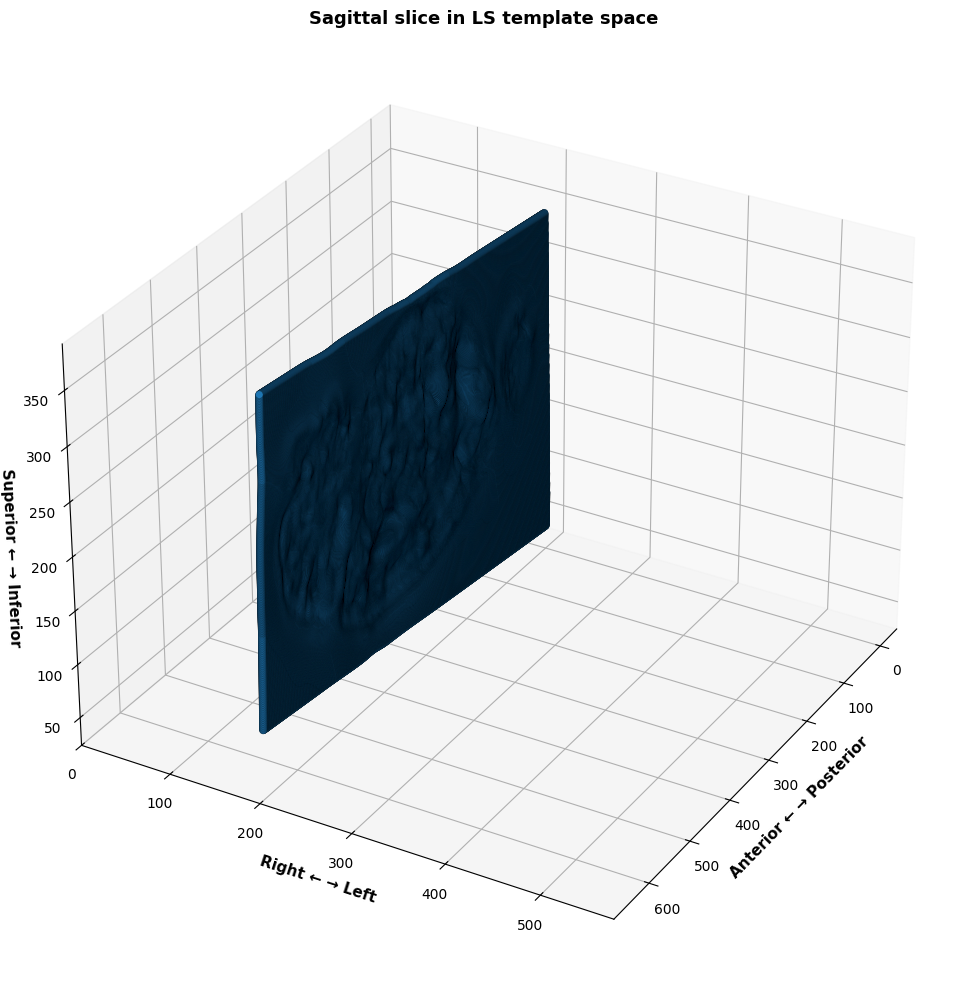

In [94]:
create_3d_plot(points=ls_template_points, space=coord_transform.ls_template)

## image backward transform

In [20]:
from aind_smartspim_transform_utils.ImageTransform import ImageTransform

image_transform = ImageTransform(
    name='smartspim_lca',
    dataset_transforms={
        'ls_to_ccf': [
            '/Users/adam.amster/Downloads/SmartSPIM_806624_2025-08-27_15-42-18_stitched_2025-08-28_13-34-06/ls_to_template_SyN_1Warp.nii.gz',
            '/Users/adam.amster/Downloads/SmartSPIM_806624_2025-08-27_15-42-18_stitched_2025-08-28_13-34-06/ls_to_template_SyN_0GenericAffine.mat'
        ]
    },
    acquisition=acquisition,
)
aligned_image = image_transform.forward_transform(
    image=raw[0, 0],
)

Image has been oriented to template: (720, 1104, 480)
No downsample factor is given. Using factor 3 based on acquisition
################################
Ants Image: ANTsImage (RAS)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (720, 1104, 480)
	 Spacing    : (0.016, 0.0144, 0.0144)
	 Origin     : (-1.5114, -1.5, 1.5)
	 Direction  : [ 1.  0.  0.  0.  1.  0.  0.  0. -1.]

Light Sheet Template: ANTsImage (RAS)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (576, 648, 440)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (-1.5114, -1.5, 1.5)
	 Direction  : [ 1.  0.  0.  0.  1.  0.  0.  0. -1.]

CCF Template: ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

################################


In [21]:
aligned_image.shape

(576, 648, 440)

In [22]:
image_transform.ls_template

ANTsImage (RAS)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (576, 648, 440)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (-1.5114, -1.5, 1.5)
	 Direction  : [ 1.  0.  0.  0.  1.  0.  0.  0. -1.]

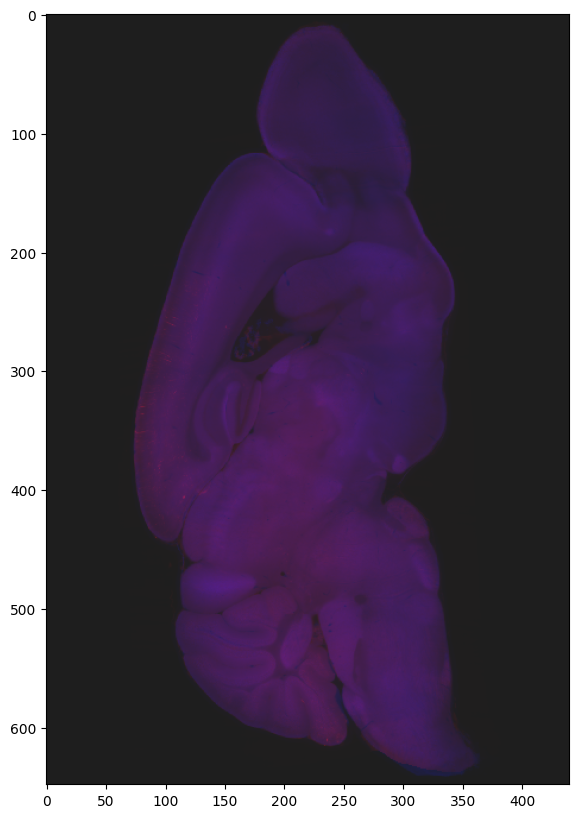

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))

aligned_slice = aligned_image[250]
aligned_slice_rgb = np.zeros_like(aligned_slice, shape=(*aligned_slice.shape, 3))
aligned_slice_rgb[:, :, 0] = aligned_slice

ls_template_slice = image_transform.ls_template[250]
ls_template_slice_rgb = np.zeros_like(ls_template_slice, shape=(*ls_template_slice.shape, 3))
ls_template_slice_rgb[:, :, 2] = ls_template_slice

ax.imshow(rescale_intensity(aligned_slice_rgb, out_range=(0, 1)), alpha=0.8)
ax.imshow(rescale_intensity(ls_template_slice_rgb, out_range=(0, 1)), alpha=0.4)
plt.show()

## try aligning points in backward direction

In [24]:
coord_transform = CoordinateTransform(
    name='smartspim_lca',
    dataset_transforms={
        'points_from_ccf': [
            '/Users/adam.amster/Downloads/SmartSPIM_806624_2025-08-27_15-42-18_stitched_2025-08-28_13-34-06/ls_to_template_SyN_1Warp.nii.gz',
            '/Users/adam.amster/Downloads/SmartSPIM_806624_2025-08-27_15-42-18_stitched_2025-08-28_13-34-06/ls_to_template_SyN_0GenericAffine.mat',
        ]
    },
    acquisition=acquisition,
    image_metadata={'shape': raw.shape[2:]}
)

In [25]:
ls_template_plane = create_coordinate_dataframe(
        height=coord_transform.ls_template.shape[1],
        width=coord_transform.ls_template.shape[2],
        z_value=190,
        col_names=['ML', 'AP', 'DV']
)

In [26]:
ls_template_plane

,ML,AP,DV
0,190.0,0.0,0.0
1,190.0,0.0,1.0
2,190.0,0.0,2.0
3,190.0,0.0,3.0
4,190.0,0.0,4.0
...,...,...,...
285115,190.0,647.0,435.0
285116,190.0,647.0,436.0
285117,190.0,647.0,437.0
285118,190.0,647.0,438.0


In [27]:
input_points = coord_transform.reverse_transform(
    points=create_coordinate_dataframe(
        height=coord_transform.ls_template.shape[1],
        width=coord_transform.ls_template.shape[2],
        z_value=190,
        col_names=['ML', 'AP', 'DV']
    ),
)

In [30]:
raw[0, 0].shape

(720, 1104, 480)

In [29]:
input_points

,ML,AP,DV
0,11576.541992,1426.997437,836.098694
1,11575.668945,1431.165161,900.364624
2,11574.794922,1435.333008,964.630554
3,11573.921875,1439.500732,1028.896484
4,11573.046875,1443.668457,1093.162354
...,...,...,...
285115,12360.749023,-41548.500000,30355.765625
285116,12359.875000,-41544.332031,30420.033203
285117,12359.001953,-41540.164062,30484.298828
285118,12358.127930,-41535.996094,30548.562500


/var/folders/2m/rxhlqtwn6yx9wb3b5l5r3s840000gp/T/ipykernel_2748/4163790641.py:19: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



ValueError: Axis limits cannot be NaN or Inf

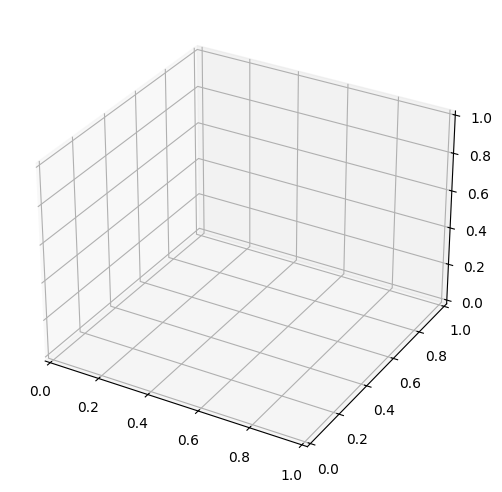

In [28]:
create_3d_plot(points=input_points, space=raw[0, 0])